# XGBoost

### Ensemble Learning

Imagine you have a complex problem to solve. Instead of relying on one super-smart model, you can use several slightly less-smart models, each looking at the data in a slightly different way, and then combined their predictions. Ensemble is a group of individual learning models that are called base learners or weak learners, whose predictions are combined to make a final prediction. Ensembles can often lead to a much more accurate overall model and are less prone to overfitting the training the data.

### Boosting

Boosting is a specific type of ensemble learning where the base learners are trained sequentially. Each new learner ties to correct the mistakes made by the previous learners. 

### Gradient Boosting

Gradient boosting is a generalisation of boosting that leverages the concept of gradient descent to build the ensemble. It starts with a simple initial prediction (e.g. the mean of the target variable for regression, or a log-odds for classification). For each data point, we calculate the residuals. 

Suppose we have a dataset $\{(x_i, y_i)\}_{i=1}^n$ where $x\in\mathbb R^p$ and $y_i\in\mathbb R$. Suppose we have a previous model, namely $F_{prev}$, whose prediction for $x_i$ is $F_{prev}(x_i)$. The "weakness" of the previous model can be defined as residual, the difference between the predicted value $F_{prev}(x_i)$ and the value $y_i$. Gradient Boosting improves the model by finding a function $h$ that reduces this residual. Suppose we have

$$
\begin{gather*}
y_1 = F_{prev}(x_1) + h(x_1)
\\
\vdots
\\
y_n = F_{prev}(x_n) + h(x_n).
\end{gather*}
$$

Then we aim to find a new function $F_{new}(x)$ as $F_{new}(x)=F_{prev}(x)+\alpha h(x)$, where we use the learning rate $\alpha$ to prevent overfitting. Let $M$ be the number of models that we are going to fit sequentially and $F_0(x)=h_0(x)$ be the prediction of the initial model. Then we have

$$
\begin{align*}
F_1(x) 
&= F_0(x) + \alpha h_1(x)
\\
&= h_0(x) + \alpha h_1(x)
\\
F_2(x) 
&= F_1(x) + \alpha h_2(x)
\\
&= h_0(x) + \alpha h_1(x) + \alpha h_2(x)
\\
\vdots
\\
F_M(x) &= h_0(x) + \alpha h_1(x) + \cdots + \alpha h_M(x)
\end{align*}
$$

where we can seee that the final model $F_M$ is the linear combination of $h_j$ for $j=0,\cdots, M$.

The algorithm can be summarised as the following:

1. Define the loss function $L(y, F(x))$ and set the learning rate $\alpha$.
2. Initialise the model $F_0(x)$ as a constant:
    $$
    F_0(x) = \arg\min_\gamma \sum_{i=1}^n L(y_i, \gamma).
    $$
3. For $m=1, \cdots, M$ iterate the following process:
    1. Find the pseudo-residual $r_{im}$ for $i=1,\cdots, m$:
        $$
        r_{im} = -\left[ \frac{\partial L(y_i, F(x_i))}{\partial F(x_i)} \right]_{F(x) = F_{m-1}(x)}
        $$
    2. Fit a base learner $g_m$ that predicts $r_{im}$. That is, fit a model using the dataset $\{(x_i, r_{im})\}_{i=1}^n$
    3. Calculate a constant $\gamma_m$:
        $$
        \gamma_m = \arg\min_\gamma \sum_{i=1}^n L(y_i, F_{m-1}(x_i) + \gamma g_m(x_i))
        $$
    4. Update hte model
        $$
        F_m(x) = F_{m-1}(x) + \alpha \gamma_m g_m(x)
        $$
4. Obtain the final model $F_M(x)$.

It is important to note that here we used $g_m(x_i)$ instead of $r_{im}$ when updating the model. This is because an individual $r_{im}$ is calculated from a certain data point $(x_i, y_i)$ and we cannot naively generalise this result. Therefore, we learn another model $g_m$ that can generalise and calculate pseudo-residual for an arbitrary $x$. 

### Gradient Tree Boosting

In the above Gradient Boosting algorithm, there is no constraint for $g_m$. Gradient Tree Boosting uses decision-tree as $g_m$. Let $J_m$ be the number of leaf nodes and $R_{jm}$ be the region for a $j$-th node for $j=1,\cdots, J_m$. A decision tree $g_m$ that fitted the dataset $\{(x_i, r_{im})\}_{i=1}^n$ is defined as 

$$
g_m(x) = \sum_{j=1}^{J_m} b_{jm}1_{x\in R_{jm}}
$$

where $1_{x\in R_{jm}}$ is an indicator funciton. After fitting $g_m$ we calculate the constant $\gamma_m$ as

$$
\gamma_m = \arg\min_\gamma \sum_{i=1}^n L(y_i, F_{m-1}(x_i) + \gamma g_m(x_i))
$$

and update the model as

$$
F_m(x) = F_{m-1}(x) + \alpha \gamma_m g_m(x)
$$

### XG Boost

XGBoost is a modified version of Gradient Tree Boosting algorithm. Here we consider two parmaeters $\gamma$ and $\lambda$ that enables regularisation. As in the previous section, we initialise the model $F_0(x)$ as a constant:

$$
F_0(x) = \arg\min_c \sum_{i=1}^n L(y_i, c).
$$

Then for $m=1,\cdots, M$ we iterate the following process:

1. Calculate the gradient $g_i$ and the Hessian $h_i$ for $i=1,\cdots, n$:
    $$
    \begin{gather*}
    g_i = \left[ \frac{\partial L(y_i, F(x_i))}{\partial F(x_i)} \right]_{F(x) = F_{m-1}(x)}
    \\
    h_i = \left[ \frac{\partial^2 L(y_i, F(x_i))}{\partial F(x_i)^2} \right]_{F(x) = F_{m-1}(x)}
    \end{gather*}
    $$
2. Fit a regression tree $\phi_m$:
    $$
    \phi_m = \arg\min_\phi \sum_{i=1}^n \frac{1}{2} h_i \left( -\frac{g_i}{h_i} - \phi(x_i) \right)^2 + \gamma T + \frac{1}{2}\lambda \|\phi\|^2
    $$
    where $T$ is the number of leaf nodes of $\phi$, $\|\phi\|^2=\sum_{j=1}^T w_j^2$ and $w_j$ is the weight of the $j$-th leaf node.
3. Update the model:
    $$
    F_m(x) = F_{m-1}(x) + \alpha \phi_m(x)
    $$
4. Obtain the final model $F_M(x) = \sum_{m=0}^M F_m(x)

Root Mean Squared Error on the test set: 30.7155

Feature Importance:
Feature f0: 88.0
Feature f1: 80.0
Feature f2: 69.0
Feature f3: 120.0
Feature f4: 17.0
Feature f5: 26.0
Feature f6: 121.0
Feature f7: 31.0
Feature f8: 18.0
Feature f9: 110.0


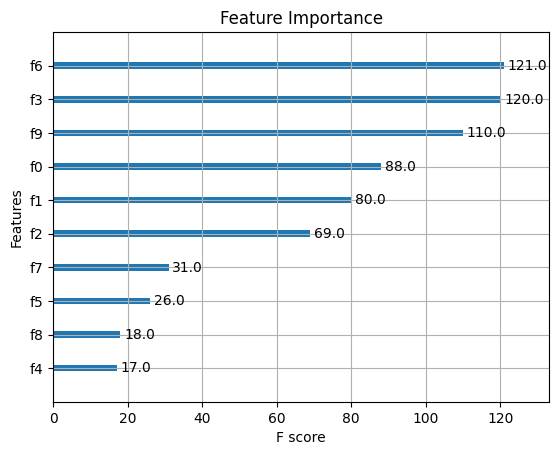

In [2]:
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.datasets import make_regression
from sklearn.metrics import root_mean_squared_error

# 1. Generate a synthetic regression dataset
X, y = make_regression(n_samples=1000, n_features=10, noise=0.1, random_state=42)

# 2. Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 3. Convert the data into DMatrix format, which is the data structure used by XGBoost
dtrain = xgb.DMatrix(X_train, label=y_train)
dtest = xgb.DMatrix(X_test, label=y_test)

# 4. Define the hyperparameters for the XGBoost model
params = {
    'objective': 'reg:squarederror',  # Regression task with squared error loss
    'eval_metric': 'rmse',           # Root Mean Squared Error for evaluation
    'eta': 0.1,                      # Learning rate (shrinkage)
    'max_depth': 3,                  # Maximum depth of each tree
    'subsample': 0.8,                # Subsample ratio of the training instances
    'colsample_bytree': 0.8,         # Subsample ratio of columns when constructing each tree
    'seed': 42                       # Random seed for reproducibility
}

# 5. Train the XGBoost model
num_round = 100  # Number of boosting rounds (trees to build)
model = xgb.train(params, dtrain, num_round)

# 6. Make predictions on the test set
y_pred = model.predict(dtest)

# 7. Evaluate the model
rmse = root_mean_squared_error(y_test, y_pred)
print(f"Root Mean Squared Error on the test set: {rmse:.4f}")

# Optional: Feature Importance
feature_importance = model.get_fscore()
print("\nFeature Importance:")
for feature, importance in feature_importance.items():
    print(f"Feature {feature}: {importance}")

# Optional: Plotting Feature Importance (requires matplotlib)
import matplotlib.pyplot as plt

xgb.plot_importance(model)
plt.title("Feature Importance")
plt.show()

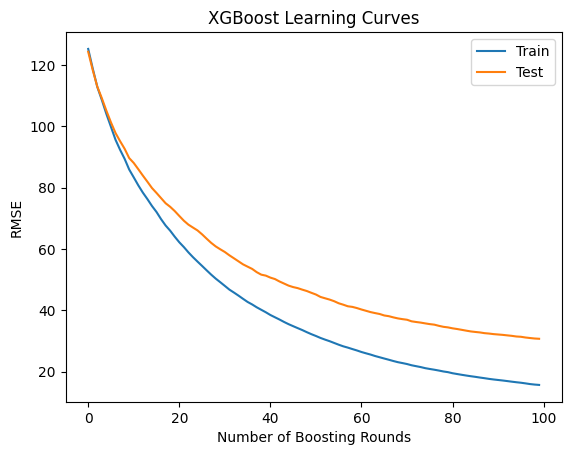

In [5]:
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.datasets import make_regression
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

# Generate data and split (as before)
X, y = make_regression(n_samples=1000, n_features=10, noise=0.1, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
dtrain = xgb.DMatrix(X_train, label=y_train)
dtest = xgb.DMatrix(X_test, label=y_test)

# Define hyperparameters
params = {
    'objective': 'reg:squarederror',
    'eval_metric': 'rmse',
    'eta': 0.1,
    'max_depth': 3,
    'subsample': 0.8,
    'colsample_bytree': 0.8,
    'seed': 42
}

# Train the model with evaluation sets and store results
num_round = 100
evals = [(dtrain, 'train'), (dtest, 'eval')]
evals_result = {}
model = xgb.train(params, dtrain, num_round, evals=evals, evals_result=evals_result, verbose_eval=False)

# Plotting Learning Curves
results = evals_result
epochs = len(results['train']['rmse'])
x_axis = range(0, epochs)

fig, ax = plt.subplots()
ax.plot(x_axis, results['train']['rmse'], label='Train')
ax.plot(x_axis, results['eval']['rmse'], label='Test')
ax.legend()
plt.ylabel('RMSE')
plt.xlabel('Number of Boosting Rounds')
plt.title('XGBoost Learning Curves')
plt.show()

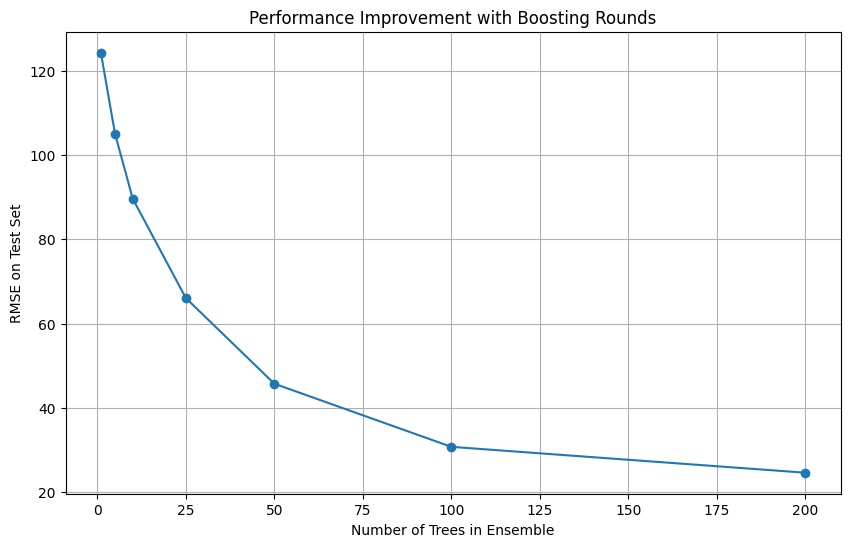

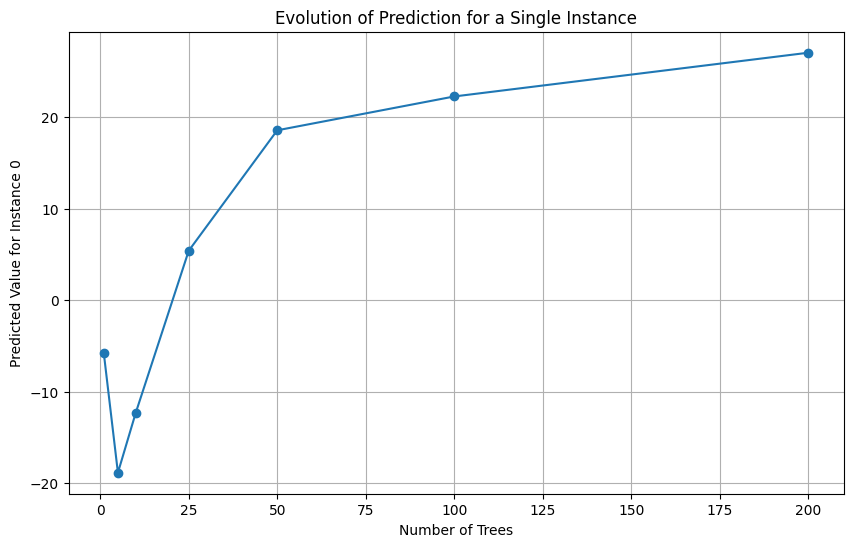

In [7]:
# Generate data and split (as before)
X, y = make_regression(n_samples=1000, n_features=10, noise=0.1, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
dtrain = xgb.DMatrix(X_train, label=y_train)
dtest = xgb.DMatrix(X_test, label=y_test)

# Train for a larger number of rounds
num_round_max = 200
model_full = xgb.train(params, dtrain, num_round_max)

# Evaluate performance with an increasing number of trees
n_trees_to_evaluate = [1, 5, 10, 25, 50, 100, num_round_max]
predictions = {}
errors = {}

for n_tree in n_trees_to_evaluate:
    model_subset = xgb.Booster(params=params)
    model_subset.load_model(model_full.save_raw())
    model_subset.set_param({'n_estimators': n_tree}) # This might not work directly like this

    # A more robust way to get predictions with a subset of trees:
    y_pred_subset = model_full.predict(dtest, iteration_range=(0, n_tree))
    predictions[n_tree] = y_pred_subset
    errors[n_tree] = root_mean_squared_error(y_test, y_pred_subset)

# Plot the RMSE as a function of the number of trees
plt.figure(figsize=(10, 6))
plt.plot(errors.keys(), errors.values(), marker='o')
plt.xlabel('Number of Trees in Ensemble')
plt.ylabel('RMSE on Test Set')
plt.title('Performance Improvement with Boosting Rounds')
plt.grid(True)
plt.show()

# Optional: Visualize predictions for a single instance
instance_index = 0
plt.figure(figsize=(10, 6))
plt.plot(n_trees_to_evaluate, [preds[instance_index] for preds in predictions.values()], marker='o')
plt.xlabel('Number of Trees')
plt.ylabel('Predicted Value for Instance {}'.format(instance_index))
plt.title('Evolution of Prediction for a Single Instance')
plt.grid(True)
plt.show()